---
title: Módulo 6
subtitle: Support Vector Machine
author:
  - name: Eloy Alvarado Narváez
    orcid: 0000-0001-7522-2327
    email: eloy.alvarado@usm.cl
    affiliations: Universidad Técnica Federico Santa María
  - name: Esteban Salgado Valenzuela
    orcid: 0000-0002-7799-0044
    affiliations: Universidad Técnica Federico Santa María
date: 12/13/2024
---

En este laboratorio, usamos la librería `sklearn.svm` para demostrar el clasificador de vectores de soporte y la máquina de vectores de soporte.

Importamos algunas de nuestras bibliotecas habituales.


In [1]:
import numpy as np
from matplotlib.pyplot import subplots, cm
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table


También cargamos librerías particulares de este laboratorio:

In [2]:
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay


Usaremos la función `RocCurveDisplay.from_estimator()` para producir varias curvas ROC, utilizando la abreviatura `roc_curve`.

In [3]:
roc_curve = RocCurveDisplay.from_estimator 


## Clasificador de Vectores de Soporte

Ahora utilizamos la función `SupportVectorClassifier()` (abreviada como `SVC()`) de `sklearn` para ajustar el clasificador de vectores de soporte para un valor dado del parámetro `C`. El argumento `C` nos permite especificar el costo de pasarse del margen. 

Cuando el argumento `C` es pequeño, los márgenes serán amplios y muchos vectores de soporte estarán en el margen o lo violarán. Cuando el argumento `C` es grande, los márgenes serán estrechos y habrá pocos vectores de soporte en el margen o tras este.

Aquí demostramos el uso de `SVC()` en un ejemplo bidimensional, de modo que podemos trazar la frontera de decisión resultante. Comenzamos generando las observaciones, las cuales pertenecen a dos clases, y verificamos si las clases son linealmente separables.


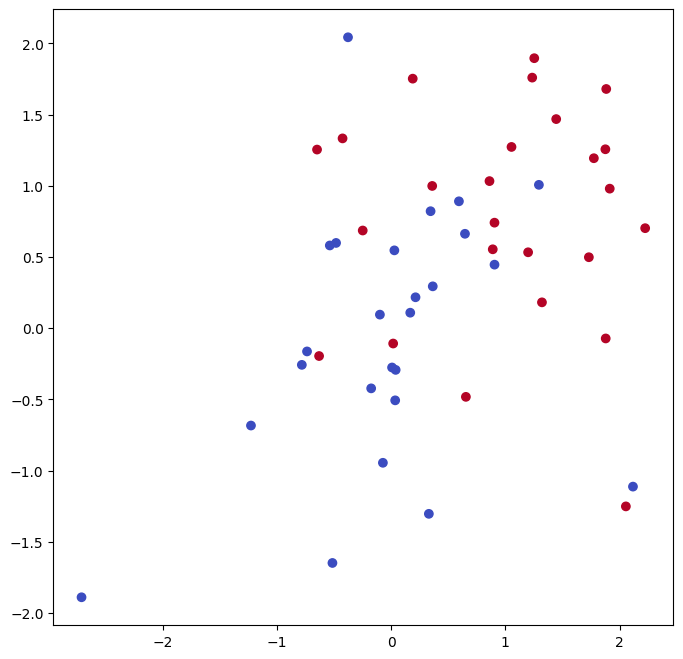

In [4]:
rng = np.random.default_rng(1)
X = rng.standard_normal((50, 2))
y = np.array([-1]*25+[1]*25)
X[y==1] += 1
fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0],
           X[:,1],
           c=y,
           cmap=cm.coolwarm);


No son separables. Ahora, ajustamos el clasificador.

In [5]:
svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X, y)


SVC(C=10, kernel='linear')

El clasificador de vectores de soporte con dos características puede ser visualizado trazando los valores de su *función de decisión*. Se ha incluido una función para esto en el paquete `ISLP` (inspirado en un ejemplo similar en la documentación de `sklearn`).


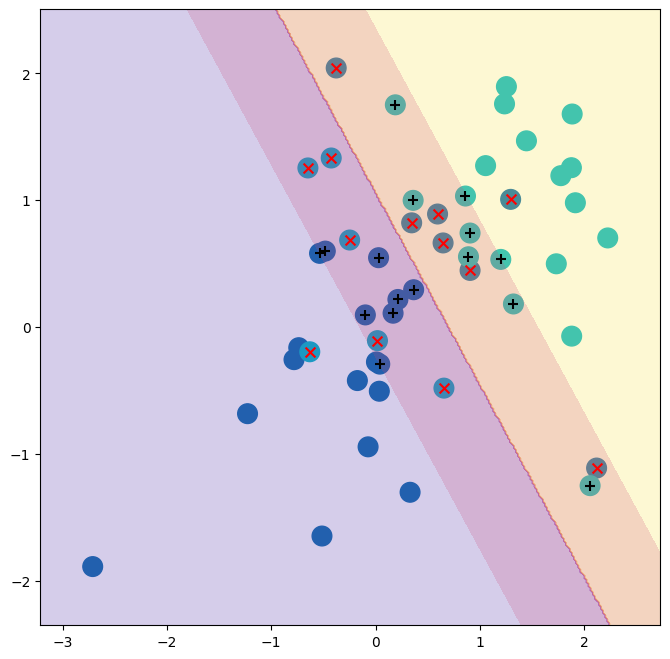

In [6]:
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_linear,
         ax=ax)


La frontera de decisión entre las dos clases es lineal (porque utilizamos el argumento `kernel='linear'`). Los vectores de soporte están marcados con `+` y las observaciones restantes se representan como círculos.

¿Qué sucedería si utilizáramos un valor más pequeño para el parámetro de costo?


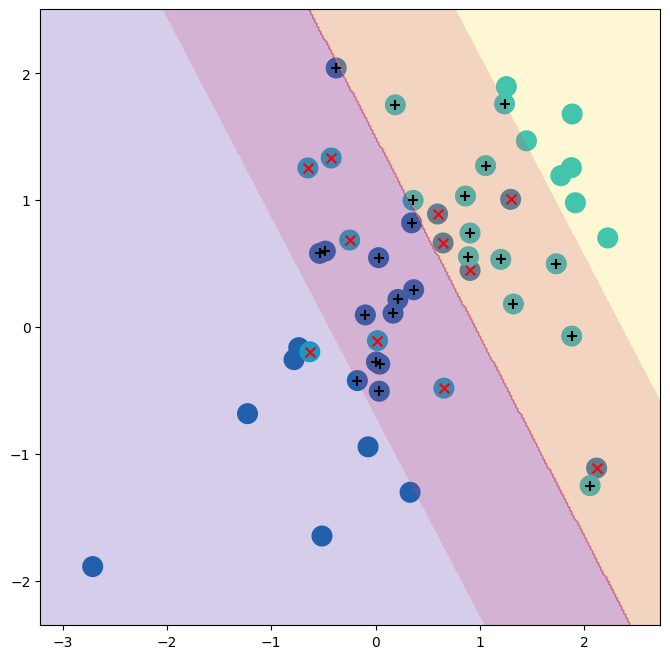

In [7]:
svm_linear_small = SVC(C=0.1, kernel='linear')
svm_linear_small.fit(X, y)
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_linear_small,
         ax=ax)


Con un valor más pequeño del parámetro de costo, obtenemos un mayor número de vectores de soporte, porque el margen ahora es más amplio. Para kernels lineales, podemos extraer los coeficientes de la frontera de decisión lineal de la siguiente manera:

In [8]:
svm_linear.coef_


array([[1.17303943, 0.77348227]])

Dado que la máquina de vectores de soporte (SVM) es un estimador en `sklearn`, podemos utilizar la maquinaria habitual para ajustarla.


In [9]:
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_linear,
                        {'C':[0.001,0.01,0.1,1,5,10,100]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X, y)
grid.best_params_


{'C': 1}

Podemos acceder fácilmente a los errores de validación cruzada (cross-validation) para cada uno de estos modelos en `grid.cv_results_`. Esto muestra muchos detalles, por lo que extraemos únicamente los resultados de precisión.


In [10]:
grid.cv_results_[('mean_test_score')]


array([0.46, 0.46, 0.72, 0.74, 0.74, 0.74, 0.74])

Observamos que `C=1` resulta en la mayor precisión de validación cruzada, con un valor de 0.74, aunque la precisión es la misma para varios valores de `C`. 

El clasificador `grid.best_estimator_` puede ser utilizado para predecir la etiqueta de clase en un conjunto de observaciones de prueba. Generamos un conjunto de datos de prueba.


In [11]:
X_test = rng.standard_normal((20, 2))
y_test = np.array([-1]*10+[1]*10)
X_test[y_test==1] += 1


Ahora predecimos las etiquetas de clase de estas observaciones de prueba. Utilizamos el mejor modelo seleccionado mediante validación cruzada para realizar las predicciones.


In [12]:
best_ = grid.best_estimator_
y_test_hat = best_.predict(X_test)
confusion_table(y_test_hat, y_test)


Truth      -1   1
Predicted        
-1          8   4
 1          2   6

Por lo tanto, con este valor de `C`, el 70% de las observaciones de prueba son clasificadas correctamente. ¿Qué sucedería si hubiéramos utilizado `C=0.001`?

In [13]:
svm_ = SVC(C=0.001,
           kernel='linear').fit(X, y)
y_test_hat = svm_.predict(X_test)
confusion_table(y_test_hat, y_test)


Truth      -1   1
Predicted        
-1          2   0
 1          8  10

En este caso, el 60% de las observaciones de prueba son clasificadas correctamente.

Ahora consideramos una situación en la que las dos clases son linealmente separables. En este caso, podemos encontrar un hiperplano de separación óptimo utilizando el estimador `SVC()`. Primero, separamos aún más las dos clases en nuestros datos simulados para que sean linealmente separables:


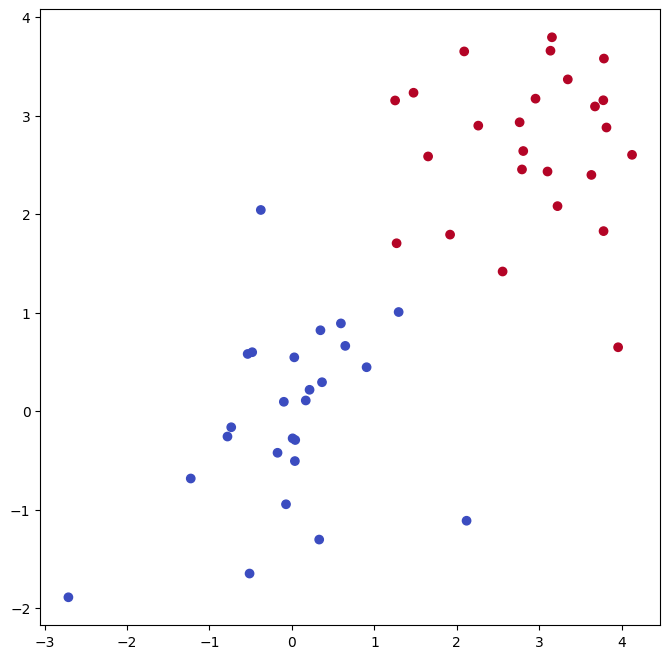

In [14]:
X[y==1] += 1.9;
fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0], X[:,1], c=y, cmap=cm.coolwarm);


Ahora las observaciones son apenas linealmente separables.


In [15]:
svm_ = SVC(C=1e5, kernel='linear').fit(X, y)
y_hat = svm_.predict(X)
confusion_table(y_hat, y)


Truth      -1   1
Predicted        
-1         25   0
 1          0  25

Ajustamos el clasificador de vectores de soporte y trazamos el hiperplano resultante, utilizando un valor muy grande de `C` para que ninguna observación sea clasificada incorrectamente.


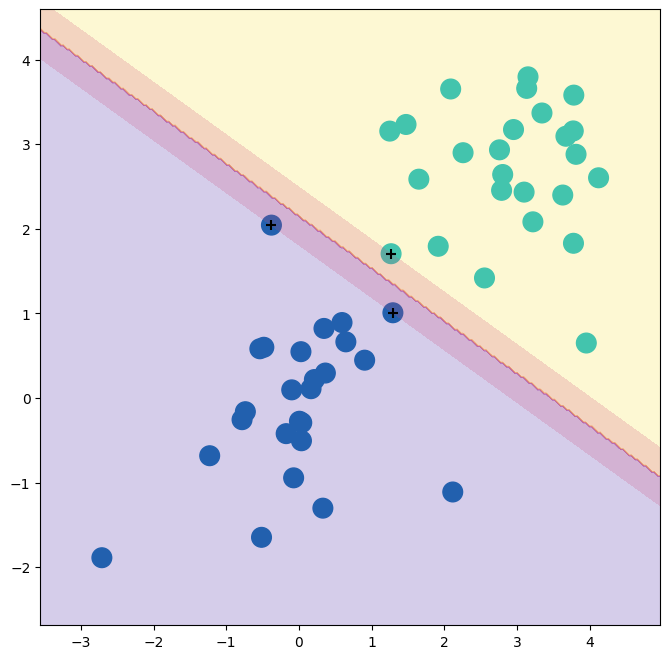

In [16]:
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_,
         ax=ax)


De hecho, no se cometieron errores en el conjunto de entrenamiento y sólo se utilizaron tres vectores de soporte. En realidad, el valor grande de `C` también implica que estos tres puntos de soporte están *en el margen* y lo definen.

*Uno podría preguntarse qué tan bueno será el clasificador en datos de prueba si depende únicamente de tres puntos de datos* Ahora probamos con un valor más pequeño de `C`.


In [17]:
svm_ = SVC(C=0.1, kernel='linear').fit(X, y)
y_hat = svm_.predict(X)
confusion_table(y_hat, y)


Truth      -1   1
Predicted        
-1         25   0
 1          0  25

Usando `C=0.1`, nuevamente no clasificamos incorrectamente ninguna observación de entrenamiento, pero también obtenemos un margen mucho más amplio y utilizamos doce vectores de soporte. Estos, en conjunto, definen la orientación de la frontera de decisión y, dado que hay más de ellos, esta es más estable.

Parece posible que este modelo funcione mejor en datos de prueba que el modelo con `C=1e5` (y, de hecho, un experimento simple con un conjunto de prueba grande lo confirmaría).


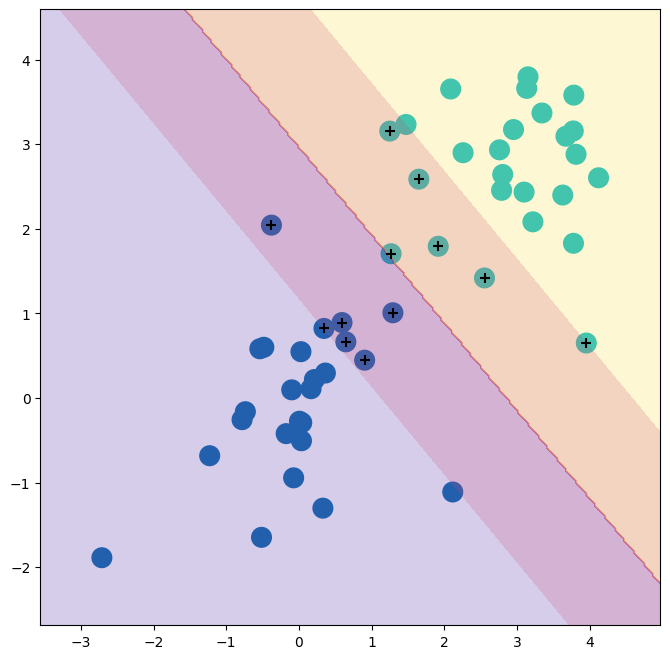

In [18]:
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_,
         ax=ax)


## Support Vector Machine
Para ajustar una SVM utilizando un kernel no lineal, una vez más usamos el estimador `SVC()`. Sin embargo, ahora utilizamos un valor diferente para el parámetro `kernel`. Para ajustar una SVM con un kernel polinomial, usamos `kernel="poly"`, y para ajustar una SVM con un kernel radial, usamos `kernel="rbf"`. 

En el primer caso, también usamos el argumento `degree` para especificar el grado del kernel polinomial, y en el segundo caso usamos `gamma` para especificar un valor de $\gamma$ para el kernel de base radial.

Primero generamos algunos datos con una frontera de clase no lineal, de la siguiente manera:


In [19]:
X = rng.standard_normal((200, 2))
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150+[2]*50)


Al graficar los datos, queda claro que la frontera entre clases es, en efecto, no lineal.


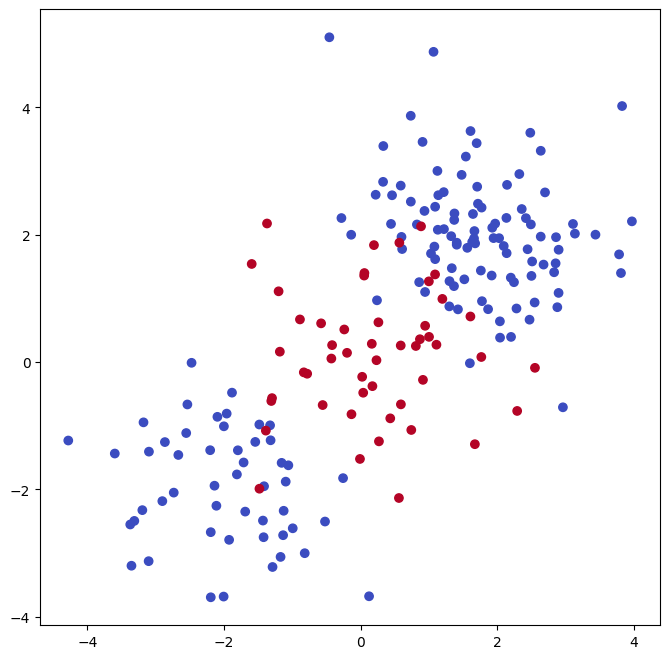

In [20]:
fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0],
           X[:,1],
           c=y,
           cmap=cm.coolwarm);


Los datos se dividen aleatoriamente en grupos de entrenamiento y prueba. Luego ajustamos los datos de entrenamiento utilizando el estimador `SVC()` con un kernel radial y $\gamma=1$:


In [21]:
(X_train, 
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                y,
                                test_size=0.5,
                                random_state=0)
svm_rbf = SVC(kernel="rbf", gamma=1, C=1)
svm_rbf.fit(X_train, y_train)


SVC(C=1, gamma=1)

La gráfica muestra que la SVM resultante tiene una frontera claramente no lineal.

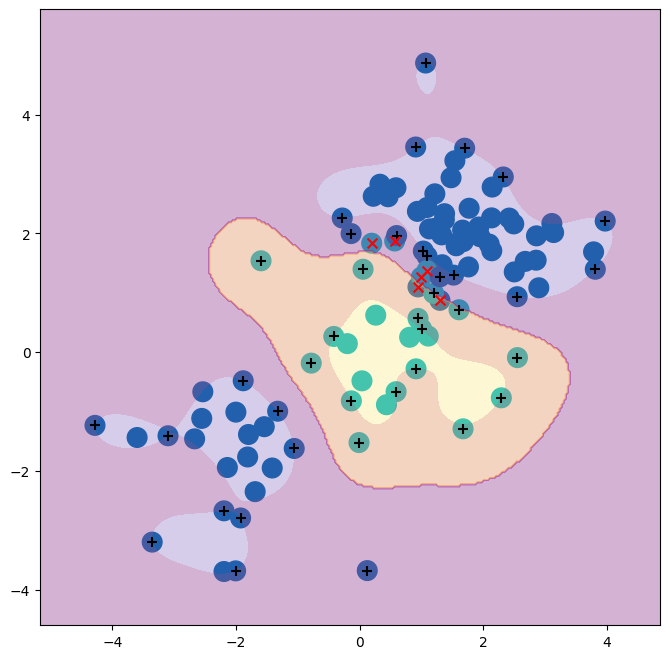

In [22]:
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         svm_rbf,
         ax=ax)


Podemos observar en la figura que hay un número considerable de errores de entrenamiento en este ajuste de SVM. Si aumentamos el valor de `C`, podemos reducir el número de errores de entrenamiento. Sin embargo, esto tiene el costo de una frontera de decisión más irregular, que parece estar en riesgo de sobreajustar los datos.

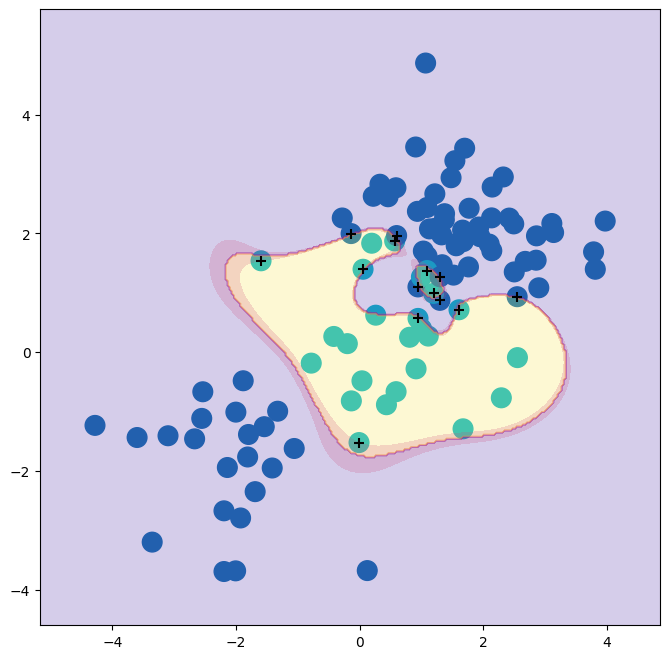

In [23]:
svm_rbf = SVC(kernel="rbf", gamma=1, C=1e5)
svm_rbf.fit(X_train, y_train)
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         svm_rbf,
         ax=ax)


Podemos realizar validación cruzada utilizando `skm.GridSearchCV()` para seleccionar la mejor combinación de $\gamma$ y `C` para una SVM con un kernel radial:

In [24]:
kfold = skm.KFold(5, 
                  random_state=0,
                  shuffle=True)
grid = skm.GridSearchCV(svm_rbf,
                        {'C':[0.1,1,10,100,1000],
                         'gamma':[0.5,1,2,3,4]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy');
grid.fit(X_train, y_train)
grid.best_params_


{'C': 1, 'gamma': 0.5}

La mejor combinación de parámetros bajo validación cruzada de cinco pliegues (*folds*) se logra con `C=1` y `gamma=0.5`, aunque varios otros valores también alcanzan el mismo resultado.


Truth       1   2
Predicted        
1          69   6
2           6  19

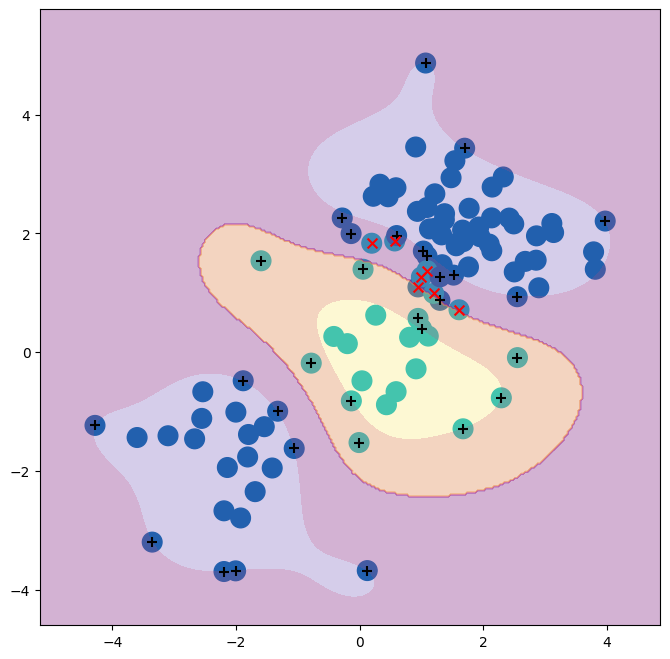

In [25]:
best_svm = grid.best_estimator_
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train,
         y_train,
         best_svm,
         ax=ax)

y_hat_test = best_svm.predict(X_test)
confusion_table(y_hat_test, y_test)


Con estos parámetros, el 12% de las observaciones de prueba son clasificadas incorrectamente por esta SVM.


## SVM con Múltiples Clases

Si la variable de respuesta es un factor que contiene más de dos niveles, entonces la función `SVC()` realizará clasificación multiclase utilizando el enfoque uno-contra-uno (cuando `decision_function_shape=='ovo'`) o uno-contra-resto {Uno-contra-resto también es conocido como uno-contra-todos.} (cuando `decision_function_shape=='ovr'`).

Exploraremos brevemente este escenario generando una tercera clase de observaciones.


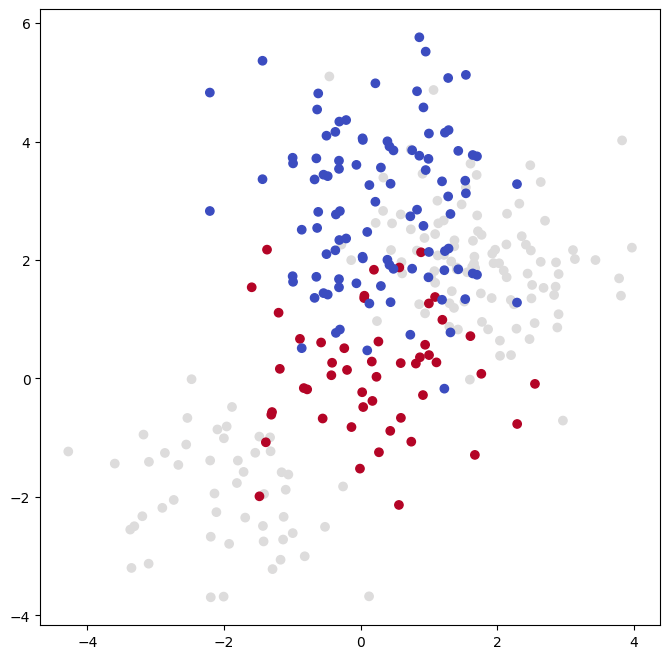

In [35]:
rng = np.random.default_rng(123)
X = np.vstack([X, rng.standard_normal((50, 2))])
y = np.hstack([y, [0]*50])
X[y==0,1] += 2
fig, ax = subplots(figsize=(8,8))
ax.scatter(X[:,0], X[:,1], c=y, cmap=cm.coolwarm);


Ahora, ajustamos SVM a los datos:

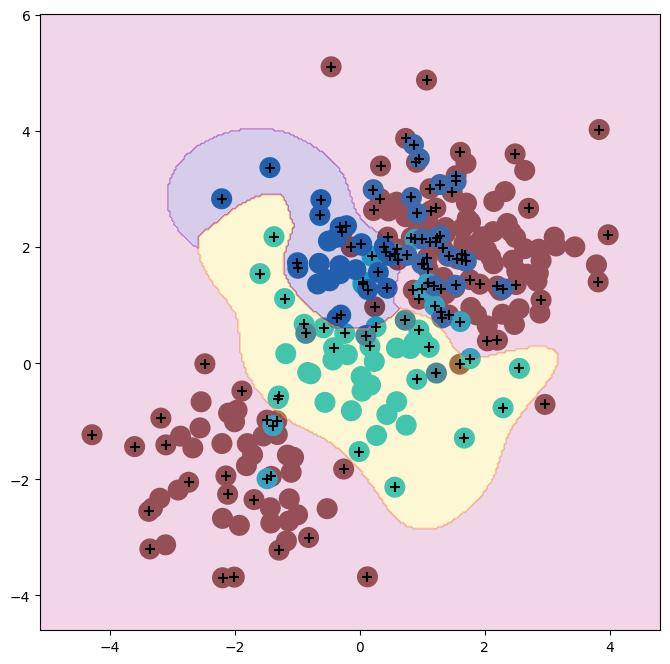

In [31]:
svm_rbf_3 = SVC(kernel="rbf",
                C=10,
                gamma=1,
                decision_function_shape='ovo');
svm_rbf_3.fit(X, y)
fig, ax = subplots(figsize=(8,8))
plot_svm(X,
         y,
         svm_rbf_3,
         scatter_cmap=cm.tab10,
         ax=ax)


La librería `sklearn.svm` también puede utilizarse para realizar regresión de vectores de soporte con una respuesta numérica, utilizando el estimador `SupportVectorRegression()`.
